In [123]:
from datetime import datetime

import numpy as np
import pandas as pd
import random
import re

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
import torchtext.vocab as vocab

from transformers import get_linear_schedule_with_warmup

import gensim

# internal imports
import evaluation.evaluate as val
from modelling import bert, util
import visualization as vis

In [75]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [76]:
# chart styling parameters
is_hakernoon = True
style_kwargs = vis.get_style_kwargs(is_hakernoon=is_hakernoon)

Download pretrained model

In [77]:
glove = vocab.GloVe(name='6B', dim=300)

w2v_path = '/Users/mariakozlova/gensim-data/word2vec-google-news-300/word2vec-google-news-300'
w2v_eng = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)

## Get and explore data

In [78]:
# https://zenodo.org/records/3355823
file_name = "ecommerceDataset.csv"
data = pd.read_csv(file_name, header=None)
data.columns = ["category", "description"]

print("Rows, cols:", data.shape)
data.head(10)

Rows, cols: (50425, 2)


,category,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
5,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
6,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
7,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
8,Household,SAF 'Ganesh Modern Art Print' Painting (Synthe...
9,Household,Paintings Villa UV Textured Modern Art Print F...


Category distribution

In [79]:
data["category"].value_counts()

Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: category, dtype: int64

Description examples

In [80]:
for category in data["category"].unique():
    row_example = data[data["category"] == category].sample(n=100).iloc[0]
    print(f"CATEGORY: {row_example['category']}\nDESCRIPTION:\n{row_example['description']}\n\n")

CATEGORY: Household
DESCRIPTION:
Riedel VINUM Cognac Glasses, Set of 2 Size:Set of 2                                                                                 |                            Style:Cognac   6416/71 Features: -Hennessy cognac glass.-Lead crystal.-Gift boxed.-Dishwasher safe. Dimensions: -7.25'' H. Collection: -Vinum collection.


CATEGORY: Books
DESCRIPTION:
Illustrated Guide to Indian Accounting Standards (Ind AS) (5th Edition May 2018) As Amended by Companies (Indian Accounting Standards) (Amendment) Rules 2018****A Comprehensive commentary on Ind AS with more than 200 illustrations, charts and case studies, Detailed comparative analysis of Ind AS and AS, Comparison of Ind AS and AS with IFRS and US GAAP, Detailed Comparative analysis of Ind AS, AS and ICDS, Analysis of impact of Ind AS in various industry sectors, Convergence of Ind AS with IFRS,**** Also Incorporating: NEW IND AS 115 - REVENUE FROM CONTRACTS WITH CUSTOMERS WITH ILLUSTRATIONS


CATEGORY: Clothing &

Handling empty values

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     50425 non-null  object
 1   description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [82]:
data[data["description"].isna()]

,category,description
39330,Clothing & Accessories,NaN


In [83]:
data.dropna(inplace=True)

## Handle duplicates

In [84]:
repeated_messages = data \
    .groupby("description", as_index=False) \
    .agg(
        n_repeats=("category", "count"),
        n_unique_categories=("category", lambda x: len(np.unique(x)))
    )

assert all(repeated_messages["n_unique_categories"] == 1), \
    f"Repeated descriptions with non-unique categories: " + \
    f"{repeated_messages[repeated_messages['n_unique_categories']] > 1}"

repeated_messages = repeated_messages[repeated_messages["n_repeats"] > 1]

print(f"Count of repeated messages (unique): {repeated_messages.shape[0]}")
print(f"Total number: {repeated_messages['n_repeats'].sum()} out of {data.shape[0]}")

repeated_messages.head(10)

Count of repeated messages (unique): 13979
Total number: 36601 out of 50424


,description,n_repeats,n_unique_categories
2,# The Silky Beans 2 KG Premium Bean Bag Filler...,4,1
3,# The Silky Beans 500 Gram Premium A-Grade for...,4,1
4,#Horror,4,1
7,(CERTIFIED REFURBISHED) HP DeskJet 2131 All-in...,2,1
8,(CERTIFIED REFURBISHED) Logitech K230 Wireless...,2,1
11,(CERTIFIED REFURBISHED) Philips BT 106 Bluetoo...,2,1
17,.42x HD Super Wide Angle Panoramic Macro Fishe...,2,1
18,0-Degree Electrical Socket Cover for Indian Pl...,2,1
20,0-Degree Women's Ankle Length Premium Cotton M...,2,1
21,1 12 4PCS Gold Metal Door Knocker Lock Doorpla...,2,1


In [85]:
data.drop_duplicates(inplace=True)
print(f"New dataset size: {data.shape}")
print(data["category"].value_counts())

New dataset size: (27802, 2)
Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: category, dtype: int64


In [86]:
category_distribution = data["category"].value_counts()

fig = px.bar(
    x=category_distribution.index,
    y=category_distribution,
    text=category_distribution,
    **style_kwargs,
)
fig.update_layout(
    title="Categories Distribution",
    width=600,
    height=300,
    xaxis_title=None,
    yaxis_title="# Items",
)

if is_hakernoon:
    vis.style_background(fig)

fig.show()

## Languages

In [124]:
def get_ascii_score(description):
    total_sym_cnt = 0
    ascii_sym_cnt = 0
    
    for sym in description:
        total_sym_cnt += 1
        if sym.isascii():
            ascii_sym_cnt += 1
    return ascii_sym_cnt / total_sym_cnt

In [132]:
w2v_eng = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)

def get_valid_eng_score(description):
    description = re.sub("[^a-z \t]+", " ", description.lower())
    total_word_cnt = 0
    eng_word_cnt = 0
    
    for word in description.split():
        total_word_cnt += 1
        if word.lower() in w2v_eng:
            eng_word_cnt += 1
    return eng_word_cnt / total_word_cnt

In [133]:
data["ascii_score"] = data["description"].apply(get_ascii_score)

In [134]:
data["eng_score"] = data["description"].apply(get_valid_eng_score)

In [108]:
data[data["ascii_score"] < 0.99].shape[0] / data.shape[0]

0.02327170707143371

In [137]:
data[data["eng_score"] < 0.7].shape[0] / data.shape[0]

0.015610387741889073

In [144]:
data[
    (data["ascii_score"] < 0.99)
    | (data["eng_score"] < 0.7)
].shape[0] / data.shape[0]

0.038306596647723186

In [145]:
data.sort_values("ascii_score").head(5)

,category,description,eng_score,ascii_score
27310,Books,Martbaan About the Author तहज़ीब के शहर लखनऊ मे...,0.833333,0.219979
23546,Books,Aughad / औघड़ About the Author साहित्य अकादमी ...,0.750000,0.228279
22135,Books,यू जी सी – नेट जूनियर रिसर्च फैलोशिप एवं सहायक...,0.000000,0.253579
22153,Books,"एन टी ए-, यू. जी. सी. (नेट /सेट/जे आर एफ) साम...",0.941176,0.256923
26625,Books,Real Estate Evam Estate Planning रियल एस्टेट ए...,0.846154,0.258291


In [146]:
data.sort_values("eng_score").head(5)

,category,description,eng_score,ascii_score
22135,Books,यू जी सी – नेट जूनियर रिसर्च फैलोशिप एवं सहायक...,0.0,0.253579
21821,Books,Nirali Brihanmumbai Mahanagarpalika Duyyam Abh...,0.0,1.000000
29743,Books,Dasham - Chhaya Bhautabignan Sikshak (2018),0.0,1.000000
24873,Books,Ghumakkadi Jindabad भारत के विभिन्‍न घुमक्‍कड़ो...,0.0,0.285266
23255,Books,Siddhartha,0.0,1.000000


## Description lengths

In [148]:
data["description_length"] = data["description"].apply(len)

In [149]:
fig = px.histogram(
    data,
    x="description_length",
    title="Descriptions Length Distribution",
    **style_kwargs,
)

if is_hakernoon:
    vis.style_background(fig)

fig.update_xaxes(title="Description Length")
fig.update_yaxes(title="Density")
fig.update_layout(legend_title_text="Category", width=800, height=400)

fig.show()


In [171]:
def shorten(annotation, max_len=15):
    if len(annotation) <= max_len:
        return annotation
    
    return annotation[:max_len - 3] + "..."


fig = px.histogram(
    data[data["description_length"] <= 5000],
    x="description_length",
    title="Descriptions Length (# Symbols) Distribution Per Category",
    color="category",
    barmode="overlay",
    histnorm="density",
    facet_row="category",
    opacity=1,
    **style_kwargs,
)

fig.for_each_annotation(lambda a: a.update(text=shorten(a.text.split("=")[1])))
    
fig.update_layout(
    legend_title_text="Category",
    width=600,
    height=600,
)

for axis in fig.layout:
    if type(fig.layout[axis]) == go.layout.YAxis:
        fig.layout[axis].title.text = ''
    if type(fig.layout[axis]) == go.layout.XAxis:
        fig.layout[axis].title.text = ''

if is_hakernoon:
    vis.style_background(fig)

fig.show()

In [18]:
print("Shortest messages, examples:\n")

for i, row in data.sort_values("description_length").iloc[:7].iterrows():
    print("{} '{}': \n{}\n".format(i, row["category"], row["description"]))

Shortest messages, examples:

31225 'Clothing & Accessories': 
BELT

25918 'Books': 
Sail

25314 'Books': 
Yes!

30433 'Books': 
On War

30411 'Books': 
On War 

25810 'Books': 
Tennis 

23015 'Books': 
Essays 



## Train test eval split

In [19]:
data_train, data_test = train_test_split(data, test_size=0.3)
data_test, data_eval = train_test_split(data_test, test_size=0.5)

data_train.shape, data_test.shape, data_eval.shape

((19461, 3), (4170, 3), (4171, 3))

## Modelling

In [20]:
inference_time_s = dict()
scores = dict()

### Baseline

In [21]:
count_vectorizer = CountVectorizer(max_features=100)
x_train_baseline, y_train_baseline = count_vectorizer.fit_transform(data_train["description"]), data_train["category"]
x_test_baseline, y_test_baseline = count_vectorizer.transform(data_test["description"]), data_test["category"]
x_eval_baseline, y_eval_baseline = count_vectorizer.transform(data_eval["description"]), data_eval["category"]

x_train_baseline = x_train_baseline.toarray()
x_test_baseline = x_test_baseline.toarray()
x_eval_baseline = x_eval_baseline.toarray()

x_train_baseline.shape, x_test_baseline.shape, x_eval_baseline.shape

((19461, 100), (4170, 100), (4171, 100))

In [22]:
ss = StandardScaler()
x_train_baseline = ss.fit_transform(x_train_baseline)
x_test_baseline = ss.transform(x_test_baseline)
x_eval_baseline = ss.transform(x_eval_baseline)

In [23]:
%%capture

lr = LogisticRegression()
lr.fit(x_train_baseline, y_train_baseline)
scores["baseline"] = balanced_accuracy_score(y_test_baseline, lr.predict(x_test_baseline))

In [24]:
print("Balanced accuracy score: {:.1f}%".format(scores["baseline"] * 100))

Balanced accuracy score: 75.2%


In [25]:
vis.draw_confusion_matrix(
    y_test_baseline,
    lr.predict(x_test_baseline),
    lr.classes_,
    label="recall",
    normalize="true",
    is_hn_style=True
)

In [26]:
vis.draw_confusion_matrix(
    y_test_baseline,
    lr.predict(x_test_baseline),
    lr.classes_,
    label="precision",
    normalize="pred",
    is_hn_style=True
)

In [27]:
vis.show_lr_feature_importance(lr, 0, count_vectorizer, is_hn_style=True)

In [28]:
vis.show_lr_feature_importance(lr, 1, count_vectorizer, is_hn_style=True)

In [29]:
vis.show_lr_feature_importance(lr, 2, count_vectorizer, is_hn_style=True)

In [30]:
vis.show_lr_feature_importance(lr, 3, count_vectorizer, is_hn_style=True)

In [31]:
eval_pred_lr = val.predict_labels(y_test_baseline, lr.predict_proba(x_test_baseline),
                                  lr.predict_proba(x_eval_baseline), lr.classes_)
eval_auto_lr = val.predict_labels(y_test_baseline, lr.predict_proba(x_test_baseline),
                                  lr.predict_proba(x_eval_baseline), lr.classes_, 0.99)
vis.show_predicted_labels_distribution(eval_pred_lr, "baseline", is_hn_style=True)

Inference time estimation

In [32]:
%%time
tic = datetime.now()
x_eval_baseline, y_eval_baseline = count_vectorizer.transform(data_eval["description"]), data_eval["category"]
x_eval_baseline = x_eval_baseline.toarray()
x_eval_baseline = ss.transform(x_eval_baseline)
_ = lr.predict_proba(x_eval_baseline)

inference_time_s["lr"] = (datetime.now() - tic).total_seconds()

CPU times: user 387 ms, sys: 1.52 s, total: 1.9 s
Wall time: 201 ms


### GRU / LSTM

Building vocabulary based on data_train

In [33]:
%%time
corpus_dict = util.CorpusDictionary(data_train["description"]) # custom class
len(corpus_dict.dictionary)

CPU times: user 1.2 s, sys: 1.82 s, total: 3.02 s
Wall time: 1.03 s


89951

In [34]:
corpus_dict.get_frequencies()[-10:]

[(')', 0.5341965983248549),
 ('a', 0.5519243615436),
 ('with', 0.5777195416473974),
 ('to', 0.5955500745079904),
 ('for', 0.630388983094394),
 ('of', 0.6383536303375983),
 ('the', 0.640563177637326),
 ('and', 0.7437438980525153),
 (',', 0.7577205693438158),
 ('.', 0.8146549509274961)]

Truncating vocabulary based on message frequencies

In [35]:
corpus_dict.truncate_dictionary(min_frequency=0.03)
len(corpus_dict.dictionary)

339

In [36]:
%%time
data_train["vector"] = corpus_dict.transform(data_train["description"])
data_test["vector"] = corpus_dict.transform(data_test["description"])
data_eval["vector"] = corpus_dict.transform(data_eval["description"])

CPU times: user 1.35 s, sys: 34 ms, total: 1.38 s
Wall time: 1.39 s


In [37]:
fig = go.Figure(data=[go.Histogram(x=data_train["vector"].apply(len), histnorm='probability')])
fig.update_layout(
    title="Lengths of messages in train dataset (words)",
    width=700,
    height=300
)
fig.show()

max_len = int(np.quantile(data_train["vector"].apply(len), q=0.95))
print("95-quantile length: {}".format(max_len))

95-quantile length: 352


In [38]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out

        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(self.n_hidden, self.n_out)


    def forward(self, sequence, lengths):
        batch_size = sequence.size(1)
        self.hidden = self._init_hidden(batch_size)
        
        embs = self.emb(sequence)
        embs = pack_padded_sequence(embs, lengths, enforce_sorted=True)
        gru_out, self.hidden = self.gru(embs, self.hidden)
        gru_out, lengths = pad_packed_sequence(gru_out)
        dropout = self.dropout(self.hidden[-1])
        output = self.out(dropout)

        return F.log_softmax(output, dim=-1)


    def _init_hidden(self, batch_size):
        return Variable(torch.zeros((1, batch_size, self.n_hidden)))

In [39]:
def get_target(label, total_labels=4):
    target = [0] * total_labels
    target[label_2_idx.get(label)] = 1
    return target

labels = set(data["category"])
label_2_idx = {label: idx for label, idx in zip(sorted(labels), range(len(labels)))}
idx_2_label = [label for label, _ in sorted(label_2_idx.items(), key=lambda x: x[1])]

data_train["target"] = data_train["category"].apply(get_target)
data_test["target"] = data_test["category"].apply(get_target)
data_eval["target"] = data_eval["category"].apply(get_target)

Train loss:	0.4269
Val loss:	0.4931


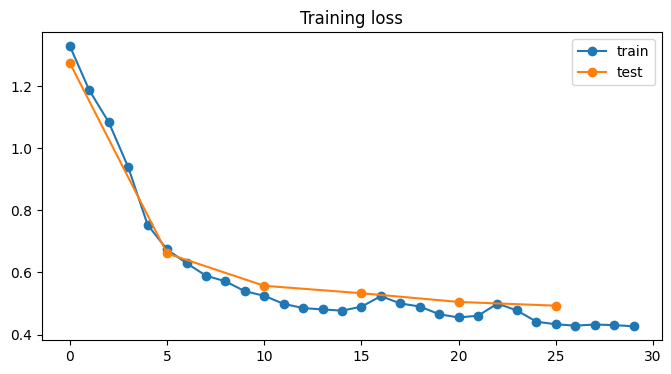

KeyboardInterrupt: 

In [40]:
ds_train = util.PaddedTextVectorDataset( # custom class
    data_train["description"],
    data_train["target"],
    corpus_dict
)
ds_test = util.PaddedTextVectorDataset(
    data_test["description"],
    data_test["target"],
    corpus_dict
)
ds_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    corpus_dict
)

train_dl = DataLoader(ds_train, batch_size=512, shuffle=True)
test_dl = DataLoader(ds_test, batch_size=512, shuffle=False)
eval_dl = DataLoader(ds_eval, batch_size=512, shuffle=False)

vocab_size = len(corpus_dict.word_to_idx)
emb_dim = 4
n_hidden = 15
n_out = len(label_2_idx)

model = GRU(vocab_size, emb_dim, n_hidden, n_out)
opt = optim.Adam(model.parameters(), 1e-2)

util.fit(model=model, train_dl=train_dl, test_dl=test_dl, loss_fn=F.cross_entropy, opt=opt, epochs=35)
torch.save(model, "models/gru")

In [ ]:
test_dl = DataLoader(ds_test, batch_size=1, shuffle=False)
eval_dl = DataLoader(ds_eval, batch_size=1, shuffle=False)

_, y_pred_test_gru, y_pred_prob_test_gru = util.predict(model, test_dl)
scores["gru"] = balanced_accuracy_score(
    data_test["category"],
    list(map(lambda x: idx_2_label[x], y_pred_test_gru))
)
print("Balanced accuracy score: {:.1f}%".format(scores["gru"] * 100))

In [ ]:
_, _, y_pred_prob_eval_gru = util.predict(model, eval_dl)

eval_pred_gru = val.predict_labels(y_test_baseline, y_pred_prob_test_gru,
                                   y_pred_prob_eval_gru, np.array(idx_2_label))
eval_auto_gru = val.predict_labels(y_test_baseline, y_pred_prob_test_gru,
                                   y_pred_prob_eval_gru, np.array(idx_2_label), 0.999)
vis.show_predicted_labels_distribution(eval_pred_gru, "GRU")

Inference time estimation

In [ ]:
%%time
tic = datetime.now()
ds_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    corpus_dict
)
eval_dl = DataLoader(ds_eval, batch_size=1, shuffle=False)
_, _, y_pred_prob_eval_gru = util.predict(model, eval_dl)

inference_time_s["gru"] = (datetime.now() - tic).total_seconds()

### GRU / LSTM + pretrained embeddings

In [ ]:
class LSTMPretrained(nn.Module):
    def __init__(self, n_hidden, n_out):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.emb.requires_grad_ = False
        self.embedding_dim = 300
        
        self.n_hidden = n_hidden
        self.n_out = n_out

        self.lstm = nn.LSTM(self.embedding_dim, self.n_hidden, num_layers=1)
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, sequence, lengths):
        batch_size = sequence.size(1)
        self.hidden = self.init_hidden(batch_size)
        embs = self.emb(sequence)
        embs = pack_padded_sequence(embs, lengths, enforce_sorted=True)
        lstm_out, (self.hidden, _) = self.lstm(embs)
        lstm_out, lengths = pad_packed_sequence(lstm_out)
        dropout = self.dropout(self.hidden[-1])
        output = self.out(dropout)
        return F.log_softmax(output, dim=-1)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros((1, batch_size, self.n_hidden)))

In [ ]:
ds_emb_train = util.PaddedTextVectorDataset(
    data_train["description"],
    data_train["target"],
    emb=glove
)
ds_emb_test = util.PaddedTextVectorDataset(
    data_test["description"],
    data_test["target"],
    emb=glove
)
ds_emb_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    emb=glove
)

dl_emb_train = DataLoader(ds_emb_train, batch_size=512, shuffle=True)
dl_emb_test = DataLoader(ds_emb_test, batch_size=512, shuffle=False)
dl_emb_eval = DataLoader(ds_emb_eval, batch_size=512, shuffle=False)

n_hidden = 50
n_out = len(label_2_idx)

emb_model = LSTMPretrained(n_hidden, n_out)
opt = optim.Adam(emb_model.parameters(), 1e-2)

util.fit(model=emb_model, train_dl=dl_emb_train, test_dl=dl_emb_test,
         loss_fn=F.cross_entropy, opt=opt, epochs=11)
torch.save(emb_model, "models/lstm_pretrained_emb")

In [ ]:
dl_emb_test = DataLoader(ds_emb_test, batch_size=1, shuffle=False)
dl_emb_eval = DataLoader(ds_emb_eval, batch_size=1, shuffle=False)

y_true_emb_test, y_pred_emb_test, y_pred_prob_emb_test = util.predict(emb_model, dl_emb_test)
scores["lstm+emb"] = balanced_accuracy_score(
    np.argmax(y_true_emb_test, axis=1),
    y_pred_emb_test
)
print("Balanced accuracy score: {:.1f}%".format(scores["lstm+emb"] * 100))

In [ ]:
_, _, y_pred_prob_eval_emb = util.predict(emb_model, dl_emb_eval)

eval_pred_emb = val.predict_labels(y_test_baseline, y_pred_prob_emb_test,
                                   y_pred_prob_eval_emb, np.array(idx_2_label))
eval_auto_emb = val.predict_labels(y_test_baseline, y_pred_prob_emb_test,
                                   y_pred_prob_eval_emb, np.array(idx_2_label), 0.99)
vis.show_predicted_labels_distribution(eval_pred_emb, "LSTM + pretrained embs")

Inference time estimation

In [ ]:
%%time
tic = datetime.now()
ds_emb_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    emb=glove
)
dl_emb_eval = DataLoader(ds_emb_eval, batch_size=1, shuffle=False)
_ = util.predict(emb_model, dl_emb_eval)
inference_time_s["lstm+emb"] = (datetime.now() - tic).total_seconds()

### BERT

In [ ]:
ds_train_bert = bert.get_dataset(
    list(data_train["description"]),
    list(data_train["target"]),
    max_vector_len=64
)
ds_test_bert = bert.get_dataset(
    list(data_test["description"]),
    list(data_test["target"]),
    max_vector_len=64
)
ds_eval_bert = bert.get_dataset(
    list(data_eval["description"]),
    list(data_eval["target"]),
    max_vector_len=64
)

In [ ]:
batch_size = 64

dl_train_bert = DataLoader(ds_train_bert, sampler=RandomSampler(ds_train_bert), batch_size=batch_size)
dl_test_bert = DataLoader(ds_test_bert, sampler=SequentialSampler(ds_test_bert), batch_size=batch_size)
dl_eval_bert = DataLoader(ds_eval_bert, sampler=SequentialSampler(ds_eval_bert), batch_size=batch_size)

In [ ]:
if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
b_model = bert.BERTModel(n_out=4)
b_model.to(device)

In [ ]:
params = list(b_model.named_parameters())

print("Embedding Layer:")
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\nFirst Transformer")

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\nOutput Layer")

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
optimizer = optim.AdamW(b_model.parameters(), lr=2e-5, eps=1e-8)

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
epochs = 2
total_steps = len(dl_train_bert) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=total_steps
)
print(f"Total steps: {total_steps}")

In [ ]:
bert.fit(b_model, dl_train_bert, dl_test_bert, optimizer, scheduler, loss_fn, device, epochs=epochs)
torch.save(b_model, "models/bert_fine_tuned")

In [ ]:
%%time
_, y_pred_prob_test_bert = bert.predict(b_model, dl_test_bert, device)

In [ ]:
scores["bert"] = balanced_accuracy_score(
    data_test["category"],
    list(map(lambda x: idx_2_label[x], np.argmax(y_pred_prob_test_bert, axis=1)))
)
print("Balanced accuracy score: {:.1f}%".format(scores["bert"] * 100))

In [ ]:
_, y_pred_prob_eval_bert = bert.predict(b_model, dl_eval_bert, device)

eval_pred_bert = val.predict_labels(y_test_baseline, y_pred_prob_test_bert,
                                    y_pred_prob_eval_bert, np.array(idx_2_label))
eval_auto_bert = val.predict_labels(y_test_baseline, y_pred_prob_test_bert,
                                    y_pred_prob_eval_bert, np.array(idx_2_label), 0.999)
vis.show_predicted_labels_distribution(eval_pred_bert, "BERT fine-tuned")

Inference time estimation

In [ ]:
%%time
tic = datetime.now()
ds_eval_bert = bert.get_dataset(
    list(data_eval["description"]),
    list(data_eval["target"]),
    max_vector_len=64
)
dl_eval_bert = DataLoader(ds_eval_bert, sampler=SequentialSampler(ds_eval_bert), batch_size=batch_size)
_ = bert.predict(b_model, dl_eval_bert, device)
inference_time_s["bert"] = (datetime.now() - tic).total_seconds()

## Choosing the model

Quality

In [ ]:
print(
    "Balanced accuracy scores\n{}".format(
        "\n".join(["{}: {:.1f}%".format(method, score * 100) for method, score in scores.items()])
    )
)

Inference times

In [ ]:
inference_time = pd.DataFrame({
    "sec": list(inference_time_s.values()),
    "method": list(inference_time_s.keys())
})
inference_time["secs_per_message"] = inference_time["sec"] / data_eval.shape[0]

print("Inference time per message estimation:\n{}".format(inference_time))

## Mislabelling examples

In [ ]:
for i, (label_true, label_pred) in enumerate(zip(data_eval["category"], eval_pred_emb)):
    if label_true != label_pred and label_pred != "UNK":
        print("Idx: {}\nTrue: {}\nPredicted: {}\nDescription:\n{}\n\n".format(
            i,
            label_true,
            label_pred,
            data_eval["description"].iloc[i]
        ))